In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

/home/anson/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = pd.read_csv('../data/processed/qm9_clean.csv')


In [4]:
words = df['smiles'].astype(str).tolist()

In [5]:
words[:10]

['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N']

In [6]:
len(words)

133885

In [7]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

print(itos)

{1: '#', 2: '(', 3: ')', 4: '+', 5: '-', 6: '1', 7: '2', 8: '3', 9: '4', 10: '5', 11: '=', 12: 'C', 13: 'F', 14: 'H', 15: 'N', 16: 'O', 17: '[', 18: ']', 0: '.'}


In [79]:
# dataset
def build_dataset(words):
    block_size = 8

    X, Y =  [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            # print(''.join(itos[i] for i in context), ' --->' , itos[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8* len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        
    

torch.Size([1736714, 8]) torch.Size([1736714])
torch.Size([217450, 8]) torch.Size([217450])
torch.Size([217124, 8]) torch.Size([217124])


In [80]:
len(words)

133885

In [81]:
n1

107108

In [82]:
n2

120496

In [89]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(19,10, generator=g)
W1 = torch.randn((80, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200,  19), generator=g)
b2 = torch.randn(19, generator=g)

parameters = [C, W1, b1, W2, b2]

In [90]:
sum(p.nelement() for p in parameters)

20209

In [91]:
for p in parameters:
    p.requires_grad = True

In [92]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [93]:
lri = []
lossi = []
stepi = []

In [95]:

for i in range(50000):
    
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]]

    h = torch.tanh(emb.view(-1,80) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(14), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
# print(loss.item())


In [96]:
loss.item()

1.252903699874878

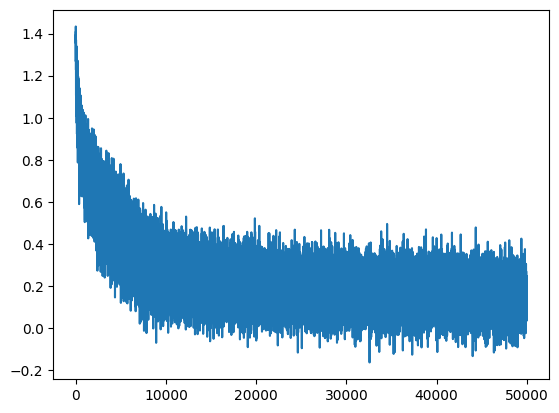

In [97]:
plt.plot(stepi, lossi)

In [98]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

RuntimeError: shape '[-1, 6]' is invalid for input of size 17396000

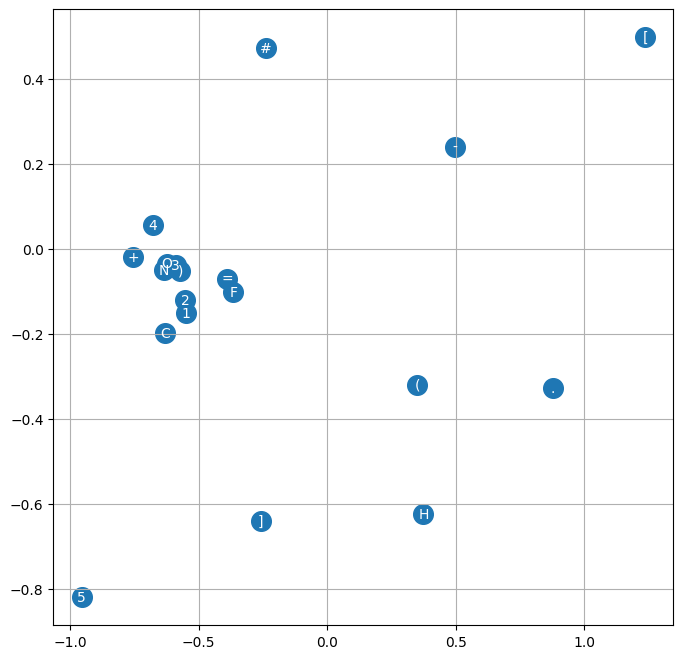

In [99]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white' )
plt.grid('minor')

In [106]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 8
for _ in range(20):
    # block_size=3
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor( [context] )] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context [1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

CN1C2CC22.
CC1CC1CC12.
CC1CC13C12.
COCC12CC1C1OO.
CC1CCCCO(OO)C#N.
OCC1CC(O)C2OC(=N)C=C1.
CN#CC(C)2.
O=C1CC=CC=C1.
CCC(O)C(O))1)C11.
CCC1OC2C1C1.
[NH3+]CC3=3NCC23.
OCC11CC(CO)C1.
OC12CC(CO)CC1.
CO=C1C=N#C.
OC1C(C1)N=N(N1)C#O)C1.
OC12C3C3C3CN22C(C)C14.
C1CC1=CC=CC1.
NC(=O)C(CO)C2.
CC1C(C)C21.
CC(CCC1CC.


In [ ]:
# # --- SAMPLING BLOCK ---
# g = torch.Generator().manual_seed(2147483647 + 10)

# # The model's "brain" (W1) was trained for 8 atoms. 
# # We must give it 8 atoms to look at.
# block_size = 8 

# for _ in range(20):
#     out = []
#     # This must create [0, 0, 0, 0, 0, 0, 0, 0]
#     context = [0] * block_size 
    
#     while True:
#         # 1. This produces a tensor of shape (1, 8, 10)
#         emb = C[torch.tensor([context])] 
        
#         # 2. Because context has 8 items, view(1, -1) creates (1, 80)
#         # 3. Now (1, 80) @ (80, 200) works perfectly !
#         h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        
#         logits = h @ W2 + b2
#         probs = F.softmax(logits, dim=1)
#         ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
#         context = context[1:] + [ix]
#         out.append(ix)
#         if ix == 0:
#             break

#     print(''.join(itos[i] for i in out))